## 2. Python for spatial data - libraries, operations

In this class, we will learn about the most common and useful Python libraries for working with spatial data. The provided examples include both toy cases, as well as cases typically encountered in real-world problems.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import shapely

In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

### Points, LineStrings, Polygons

Let's do some drawing to gain an understanding of how Points, LineStrings, and Polygons are generated, stored, and manipulated in Python

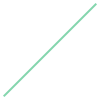

In [3]:
A = Point(0,0)
B = Point(1,1)
C = Point(1,0)

start, end = [(A.x, A.y), (B.x, B.y)]

AB = LineString([start, end])
AB

In [4]:
gdf = gpd.GeoDataFrame({"geometry" : [C, AB]})
gdf

,geometry
0,POINT (1.00000 0.00000)
1,"LINESTRING (0.00000 0.00000, 1.00000 1.00000)"


<AxesSubplot:>

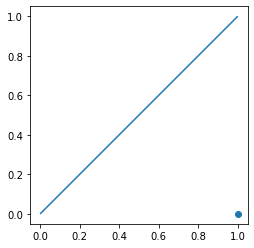

In [5]:
gdf.plot()

In [6]:
pointList = [A, B, C]
polygon = Polygon([[p.x, p.y] for p in pointList])

# shapely is smart enough to close the polygon for you, so you don't have to pass the first point in the end again
print(polygon)

POLYGON ((0 0, 1 1, 1 0, 0 0))


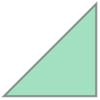

In [7]:
polygon

### Spatial manipulations

In [8]:
D = Point(0.5, 0)
E = Point(0.5, 1)
F = Point(1.5, 0)

pointList2 = [D, E, F]
polygon2 = Polygon([[p.x, p.y] for p in pointList2])

# shapely is smart enough to close the polygon for you, so you don't have to pass the first point in the end again
print(polygon2)

POLYGON ((0.5 0, 0.5 1, 1.5 0, 0.5 0))


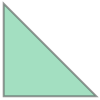

In [9]:
polygon2

In [10]:
gdf_poly_1 = gpd.GeoDataFrame({"geometry" : [polygon]})
gdf_poly_2 = gpd.GeoDataFrame({"geometry" : [polygon2]})
gdf_poly_2

,geometry
0,"POLYGON ((0.50000 0.00000, 0.50000 1.00000, 1...."


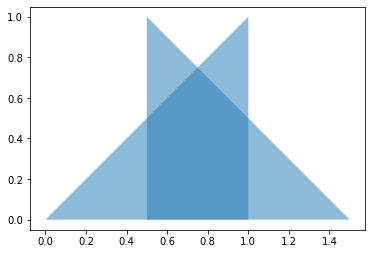

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
gdf_poly_1.plot(ax=ax, alpha=0.5)
gdf_poly_2.plot(ax=ax, alpha=0.5)
plt.show()

#### Intersection:

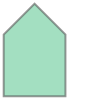

In [12]:
polygon.intersection(polygon2)

#### Difference:

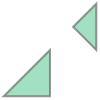

In [13]:
polygon.difference(polygon2)

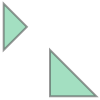

In [14]:
polygon2.difference(polygon)

In [15]:
difference = polygon2.difference(polygon)
print(type(difference))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


#### Symmetric difference:

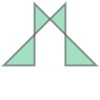

In [16]:
polygon.symmetric_difference(polygon2)

#### Union:

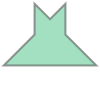

In [17]:
polygon.union(polygon2)

#### Boundary union:

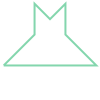

In [18]:
polygon.union(polygon2).boundary

In [19]:
b_union = polygon.union(polygon2).boundary
print(type(b_union))

<class 'shapely.geometry.linestring.LineString'>


#### Distance between point and polygon

In [20]:
poly = Polygon([(0, 0), (2, 8), (14, 10), (6, 1)])
point = Point(12, 4)

In [21]:
dist = point.distance(poly)
print(dist)

2.491364395612199


In [22]:
buff = point.buffer(dist) 
print(type(buff))

<class 'shapely.geometry.polygon.Polygon'>


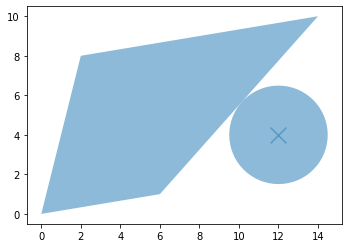

In [23]:
gdf_ = gpd.GeoDataFrame({"geometry" : [poly, point, buff]})
gdf_.plot(marker='x', markersize=250, alpha=0.5)
plt.show()

### Basic GeoPandas functionality

In [24]:
nyc = gpd.read_file("../data/New York/Borough Boundaries.geojson", driver="GeoJSON")
print(nyc.crs)
nyc.head()

epsg:4326


,boro_code,boro_name,shape_area,shape_leng,geometry
0,2,Bronx,1186612478.34,462958.187537,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,5,Staten Island,1623757282.78,325956.009,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,1,Manhattan,636602658.568,361212.476363,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,1937593020.61,738745.842046,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
4,4,Queens,3045878171.58,904191.43261,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."


Let's reproject the New York boroughs to a metric UTM coordinate reference system and compute their areas:

In [25]:
from pyproj import CRS
crs = CRS(proj='utm', zone=18, ellps='WGS84')
nyc_proj = nyc.to_crs(crs)
print(nyc_proj.crs)
nyc_proj = nyc_proj.set_index("boro_name")

nyc_proj["area"] = nyc_proj.area
nyc_proj.head()

+proj=utm +zone=18 +ellps=WGS84 +type=crs


,boro_code,shape_area,shape_leng,geometry,area
boro_name,,,,,
Bronx,2,1186612478.34,462958.187537,"MULTIPOLYGON (((593066.658 4516675.698, 593055...",1.101782e+08
Staten Island,5,1623757282.78,325956.009,"MULTIPOLYGON (((580375.284 4491060.737, 580378...",1.507494e+08
Manhattan,1,636602658.568,361212.476363,"MULTIPOLYGON (((583578.458 4504203.877, 583494...",5.910676e+07
Brooklyn,3,1937593020.61,738745.842046,"MULTIPOLYGON (((595882.111 4492983.277, 595829...",1.798996e+08
Queens,4,3045878171.58,904191.43261,"MULTIPOLYGON (((598434.302 4494444.181, 598425...",2.828166e+08


Let's get the borough boundaries:

In [26]:
nyc_proj['boundary'] = nyc_proj.boundary
nyc_proj['boundary']

boro_name
Bronx            MULTILINESTRING ((593066.658 4516675.698, 5930...
Staten Island    MULTILINESTRING ((580375.284 4491060.737, 5803...
Manhattan        MULTILINESTRING ((583578.458 4504203.877, 5834...
Brooklyn         MULTILINESTRING ((595882.111 4492983.277, 5958...
Queens           MULTILINESTRING ((598434.302 4494444.181, 5984...
Name: boundary, dtype: geometry

In [27]:
nyc_proj.head()

,boro_code,shape_area,shape_leng,geometry,area,boundary
boro_name,,,,,,
Bronx,2,1186612478.34,462958.187537,"MULTIPOLYGON (((593066.658 4516675.698, 593055...",1.101782e+08,"MULTILINESTRING ((593066.658 4516675.698, 5930..."
Staten Island,5,1623757282.78,325956.009,"MULTIPOLYGON (((580375.284 4491060.737, 580378...",1.507494e+08,"MULTILINESTRING ((580375.284 4491060.737, 5803..."
Manhattan,1,636602658.568,361212.476363,"MULTIPOLYGON (((583578.458 4504203.877, 583494...",5.910676e+07,"MULTILINESTRING ((583578.458 4504203.877, 5834..."
Brooklyn,3,1937593020.61,738745.842046,"MULTIPOLYGON (((595882.111 4492983.277, 595829...",1.798996e+08,"MULTILINESTRING ((595882.111 4492983.277, 5958..."
Queens,4,3045878171.58,904191.43261,"MULTIPOLYGON (((598434.302 4494444.181, 598425...",2.828166e+08,"MULTILINESTRING ((598434.302 4494444.181, 5984..."


You may notice that we now have two columns storing geometry objects. However, the primary geometric engine is associated with the column named `geometry`, regardless of how many geometry columns you store in your GeoDataFrame.

Now, let's create yet another geometry column containing the centroids of the borough polygons.

In [28]:
nyc_proj['centroid'] = nyc_proj.centroid
nyc_proj['centroid']

boro_name
Bronx            POINT (595538.271 4523015.179)
Staten Island    POINT (571649.442 4492572.239)
Manhattan        POINT (587152.510 4514541.830)
Brooklyn         POINT (588976.141 4499850.693)
Queens           POINT (599806.143 4506965.417)
Name: centroid, dtype: geometry

As another exercise, we can compute distances from all centroids to one we select:

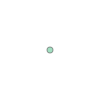

In [29]:
nyc_proj['centroid'].iloc[0]

In [30]:
nyc_proj['centroid'].iloc[0].coords

In [31]:
nyc_proj['centroid'].iloc[0].coords[0]

(595538.2714192084, 4523015.179180154)

In [32]:
centroid = nyc_proj['centroid'].iloc[0]
nyc_proj['distance'] = nyc_proj['centroid'].distance(centroid)
nyc_proj['distance']

boro_name
Bronx                0.000000
Staten Island    38696.883369
Manhattan        11921.352033
Brooklyn         24076.024503
Queens           16607.515721
Name: distance, dtype: float64

### Simple data visualisation

<AxesSubplot:>

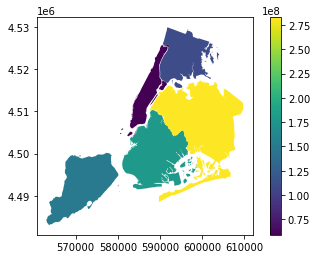

In [33]:
nyc_proj.plot(column = "area", legend=True)

As you remember, the primary geometric information is stored in the `geometry` column. However, we can change it:

<AxesSubplot:>

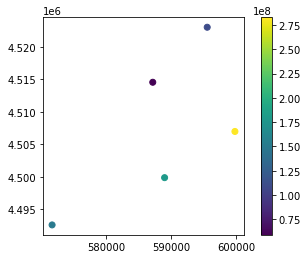

In [34]:
nyc_proj = nyc_proj.set_geometry("centroid")
nyc_proj.plot("area", legend=True)

We can also plot both geometric collections on top of each other as layers, using simple `matplotlib` functionality.

<AxesSubplot:>

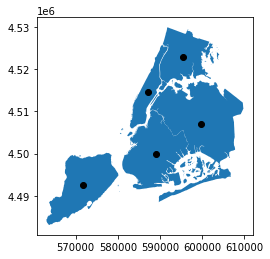

In [35]:
ax = nyc_proj["geometry"].plot()
nyc_proj["centroid"].plot(ax=ax, color="black")

A common geometric manipulation you may come across when working with spatial data is computing [**convex hulls**](https://en.wikipedia.org/wiki/Convex_hull).

<AxesSubplot:>

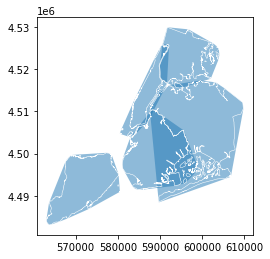

In [36]:
# remember to switch the geometry back
nyc_proj = nyc_proj.set_geometry("geometry")

nyc_proj["convex_hull"] = nyc_proj.convex_hull

ax = nyc_proj["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
nyc_proj["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

### Real-world example: Yerevan city polygon

Yerevan coordinate reference system before projection:  epsg:4326
Yerevan coordinate reference system after projection:  +proj=utm +zone=38 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


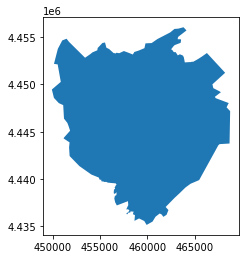

In [37]:
# load yerevan city from openstreetmap using osmmnx api
city = ox.geocode_to_gdf("Yerevan, Armenia")
print("Yerevan coordinate reference system before projection: ", city.crs)
city = ox.projection.project_gdf(city)
ax = city.plot(ec='none')
#_ = ax.axis('off')
print("Yerevan coordinate reference system after projection: ", city.crs)

If you check [OpenStreetMap](https://www.openstreetmap.org/relation/364087#map=12/40.1496/44.4709), Yerevan's polygon geometry that has been uploaded to OpenStreetMap does not contain the airport.
Let's try to add the airport as a circle buffer to our main poalygon with the tools we have learned so far.
To find the Yerevan Airport coordinates, we simply [google](https://www.google.com/search?q=yerevan+airport+coordinates&sxsrf=ALeKk01o-fmV7q8kvz_dxpUX17fAmxqEWA%3A1624282787636&ei=o5bQYJChJrmC9u8PlYW3QA&oq=yerevan+airport+coo&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCCEQoAEyBQghEKABOgcIABBHELADOggILhCRAhCTAjoCCAA6CAguEMcBEK8BOgIILjoHCCMQJxCdAjoECCMQJzoECC4QQzoMCCMQJxCdAhBGEIACOgsILhDHARCvARCTAjoGCAAQFhAeUNPLySJY1NzJImDa58kiaANwAngAgAG7AYgB3RaSAQQwLjE5mAEAoAEBqgEHZ3dzLXdpesgBCMABAQ&sclient=gws-wiz) it: 40.1492° N, 44.3989° E.

<AxesSubplot:>

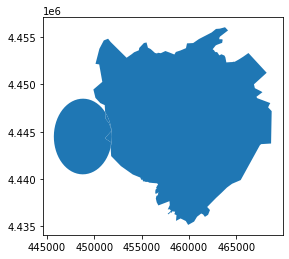

In [38]:
# Airport coordinates 40.1492° N, 44.3989° E.
# 1km = 0.00899928°
circle = Point(44.3989, 40.1492).buffer(4*0.00899928)
c = gpd.GeoSeries(circle)

from pyproj import CRS
crs = CRS.from_epsg(4326)

df1 = gpd.GeoDataFrame({'geometry': c, 'df1':[1]}, crs=crs)
df = df1.to_crs(city.crs)
city_union = gpd.overlay(df, city, how='union')
city_union.plot()

In [39]:
city_union

,df1,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance,geometry
0,1.0,40.253947,40.065685,44.632871,44.411555,258460970.0,relation,364087.0,40.177612,44.512585,"Yerevan, Armenia",boundary,administrative,0.857025,"MULTIPOLYGON (((451868.004 4444470.221, 451850..."
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((451733.629 4443336.600, 451728.586 4..."
2,NaN,40.253947,40.065685,44.632871,44.411555,258460970.0,relation,364087.0,40.177612,44.512585,"Yerevan, Armenia",boundary,administrative,0.857025,"POLYGON ((451154.402 4447058.966, 451111.433 4..."


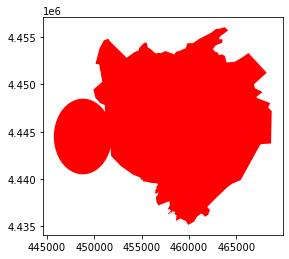

In [40]:
from shapely.ops import cascaded_union
polygons = [city_union['geometry'].iloc[0], city_union['geometry'].iloc[1], city_union['geometry'].iloc[2]]
boundary = gpd.GeoSeries(cascaded_union(polygons))
boundary.plot(color = 'red')
plt.show()

<AxesSubplot:>

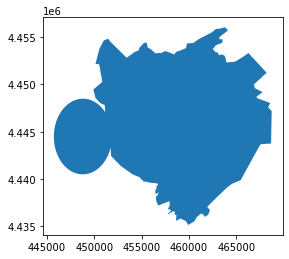

In [41]:
# convert it to a GeoDataFrame
yerevan = gpd.GeoDataFrame({'geometry': boundary}, crs=city.crs)
yerevan.plot()

### Spatial analysis with geometry overlays

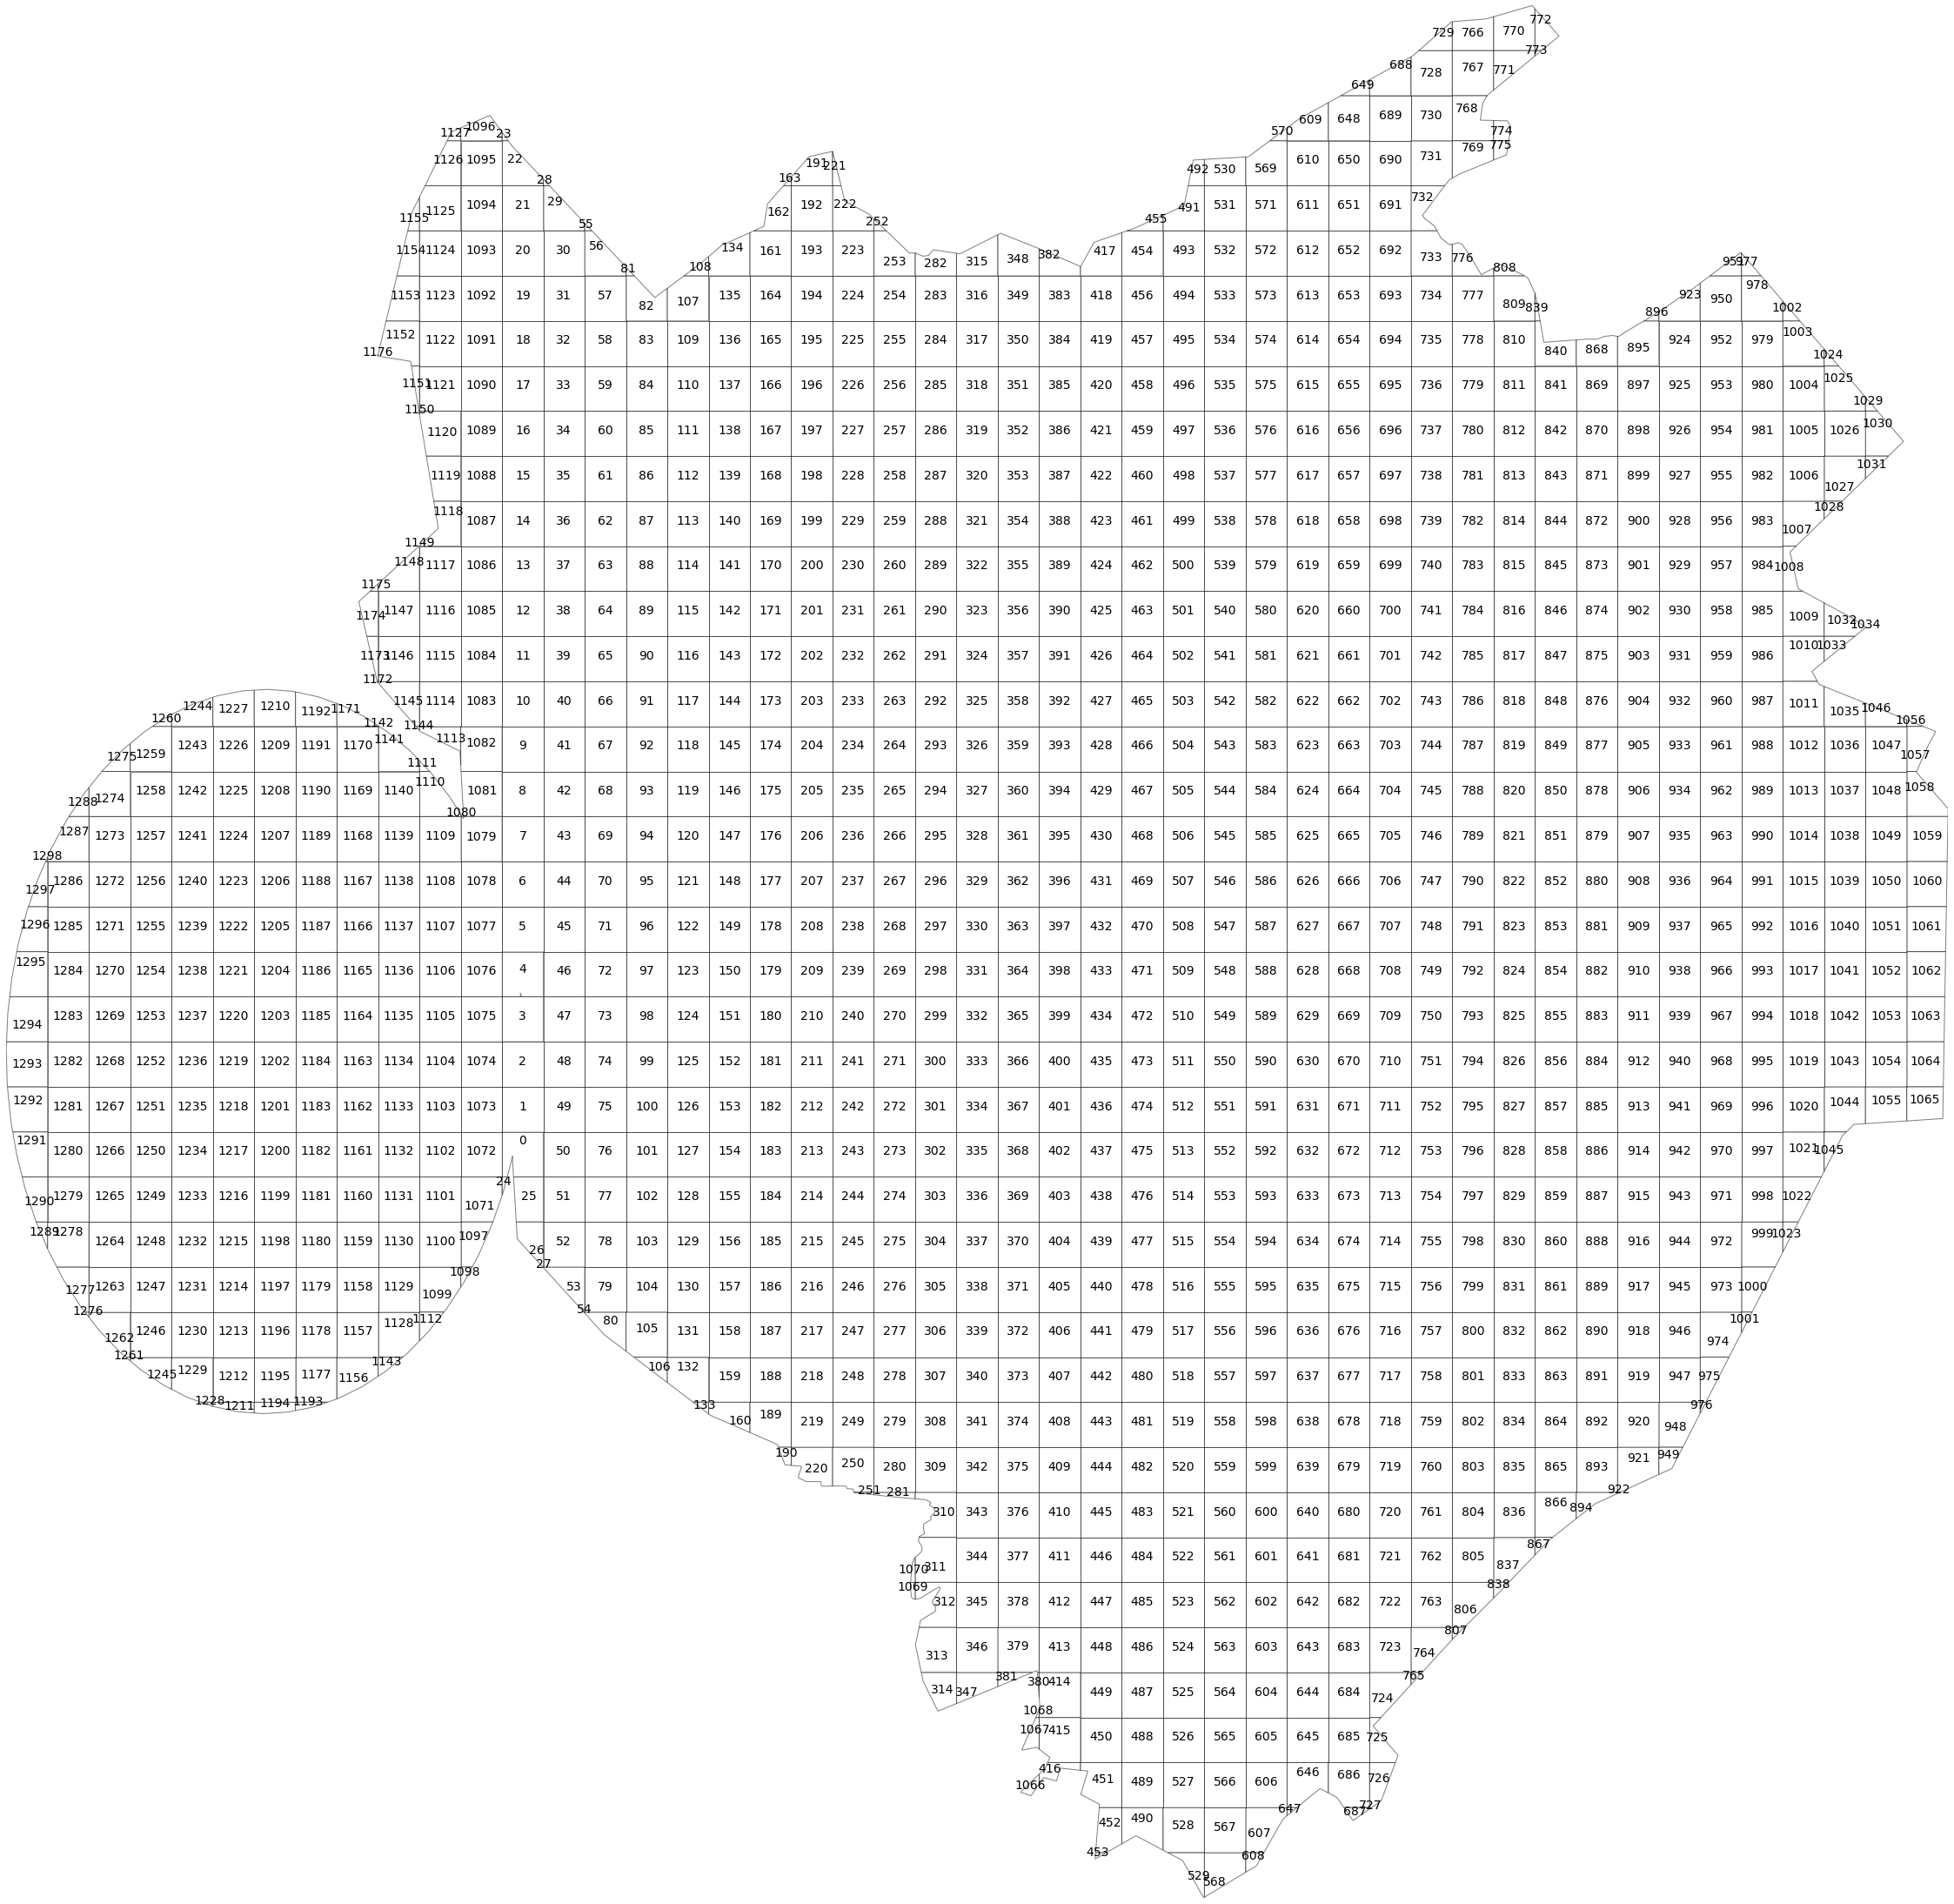

In [42]:
# make the geometry a multipolygon if it's not already
geometry = yerevan['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=500)

yerevan['coords'] = yerevan['geometry'].apply(lambda x: x.representative_point().coords[:])
yerevan['coords'] = [coords[0] for coords in yerevan['coords']]

polylist = [p for p in geometry_cut]

west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p,
                 horizontalalignment='center', size=14)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [43]:
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = yerevan.geometry.crs
polyframe.head()

,geometry
0,"POLYGON ((451733.629 4443336.600, 451728.586 4..."
1,"POLYGON ((451609.763 4443603.633, 451609.763 4..."
2,"POLYGON ((451609.763 4444100.702, 451609.763 4..."
3,"POLYGON ((451609.763 4444597.770, 451609.763 4..."
4,"POLYGON ((451609.763 4445094.838, 451609.763 4..."


### Restaurant counts per grid cell

In [44]:
# get everything tagged amenity,
# and everything tagged landuse = retail or commercial,
# and everything tagged highway = bus_stop
tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.geometries_from_place("Yerevan, Armenia", tags)
print(gdf.shape)
gdf.head()

(5825, 231)


amenity fuel:cng                  name  \
element_type osmid                                                        
node         292950822              fuel      yes            CNG methan   
             370047088  place_of_worship      NaN  Սուրբ Սարգիս եկեղեցի   
             370050884              bank      NaN         Converse Bank   
             370050885              bank      NaN         Converse Bank   
             370050886              bank      NaN         Converse Bank   

                                         geometry        denomination  \
element_type osmid                                                      
node         292950822  POINT (44.47218 40.16121)                 NaN   
             370047088  POINT (44.50225 40.17703)  armenian_apostolic   
             370050884  POINT (44.51245 40.17676)                 NaN   
             370050885  POINT (44.51940 40.18350)                 NaN   
             370050886  POINT (44.51593 40.18847)                 NaN   

                                        name:de                 name:en  \
element_type osmid                                                        
node         292950822                      NaN                     NaN   
             370047088  Sankt-Sarkis-Kathedrale  Saint Sarkis Cathedral   
             370050884                      NaN                     NaN   
             370050885                      NaN                     NaN   
             370050886                      NaN                     NaN   

                                     name:hy                  name:ru  \
element_type osmid                                                      
node         292950822                   NaN                      NaN   
             370047088  Սուրբ Սարգիս եկեղեցի  Церковь Святого Саркиса   
             370050884          Կոնվերս բանկ             Конверс банк   
             370050885          Կոնվերս բանկ             Конверс банк   
             370050886          Կոնվերս բանկ             Конверс банк   

                         religion  ... shelter_type tunnel language:ru  \
element_type osmid                 ...                                   
node         292950822        NaN  ...          NaN    NaN         NaN   
             370047088  christian  ...          NaN    NaN         NaN   
             370050884        NaN  ...          NaN    NaN         NaN   
             370050885        NaN  ...          NaN    NaN         NaN   
             370050886        NaN  ...          NaN    NaN         NaN   

                       name:ka service_times language:hy name:be name:uk  \
element_type osmid                                                         
node         292950822     NaN           NaN         NaN     NaN     NaN   
             370047088     NaN           NaN         NaN     NaN     NaN   
             370050884     NaN           NaN         NaN     NaN     NaN   
             370050885     NaN           NaN         NaN     NaN     NaN   
             370050886     NaN           NaN         NaN     NaN     NaN   

                       name:am ways  
element_type osmid                   
node         292950822     NaN  NaN  
             370047088     NaN  NaN  
             370050884     NaN  NaN  
             370050885     NaN  NaN  
             370050886     NaN  NaN  

[5 rows x 231 columns]

In [45]:
# get the restaurants
restaurants = gdf[(gdf["amenity"] == "restaurant") & \
                  (gdf["geometry"].geom_type == "Point")].dropna(axis=1, how="any")
print(restaurants.shape)
restaurants.reset_index(inplace=True, drop=True)
restaurants

(374, 2)


C:\Users\gevor\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,amenity,geometry
0,restaurant,POINT (44.52487 40.17832)
1,restaurant,POINT (44.52044 40.17839)
2,restaurant,POINT (44.51909 40.18829)
3,restaurant,POINT (44.51324 40.17054)
4,restaurant,POINT (44.51769 40.18303)
...,...,...
369,restaurant,POINT (44.43781 40.17472)
370,restaurant,POINT (44.51443 40.18852)
371,restaurant,POINT (44.51114 40.17435)
372,restaurant,POINT (44.51349 40.18227)


In [46]:
restaurant_shp = restaurants[['geometry']]
restaurant_shp= restaurant_shp.copy()
restaurant_shp

C:\Users\gevor\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry
0,POINT (44.52487 40.17832)
1,POINT (44.52044 40.17839)
2,POINT (44.51909 40.18829)
3,POINT (44.51324 40.17054)
4,POINT (44.51769 40.18303)
...,...
369,POINT (44.43781 40.17472)
370,POINT (44.51443 40.18852)
371,POINT (44.51114 40.17435)
372,POINT (44.51349 40.18227)


In [47]:
# convert crs
restaurant_shp.geometry = restaurant_shp.geometry.to_crs(polyframe.crs)
restaurant_shp.head()

C:\Users\gevor\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry
0,POINT (459548.396 4447657.080)
1,POINT (459171.818 4447667.750)
2,POINT (459062.500 4448766.863)
3,POINT (458553.350 4446799.063)
4,POINT (458940.383 4448183.700)


C:\Users\gevor\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


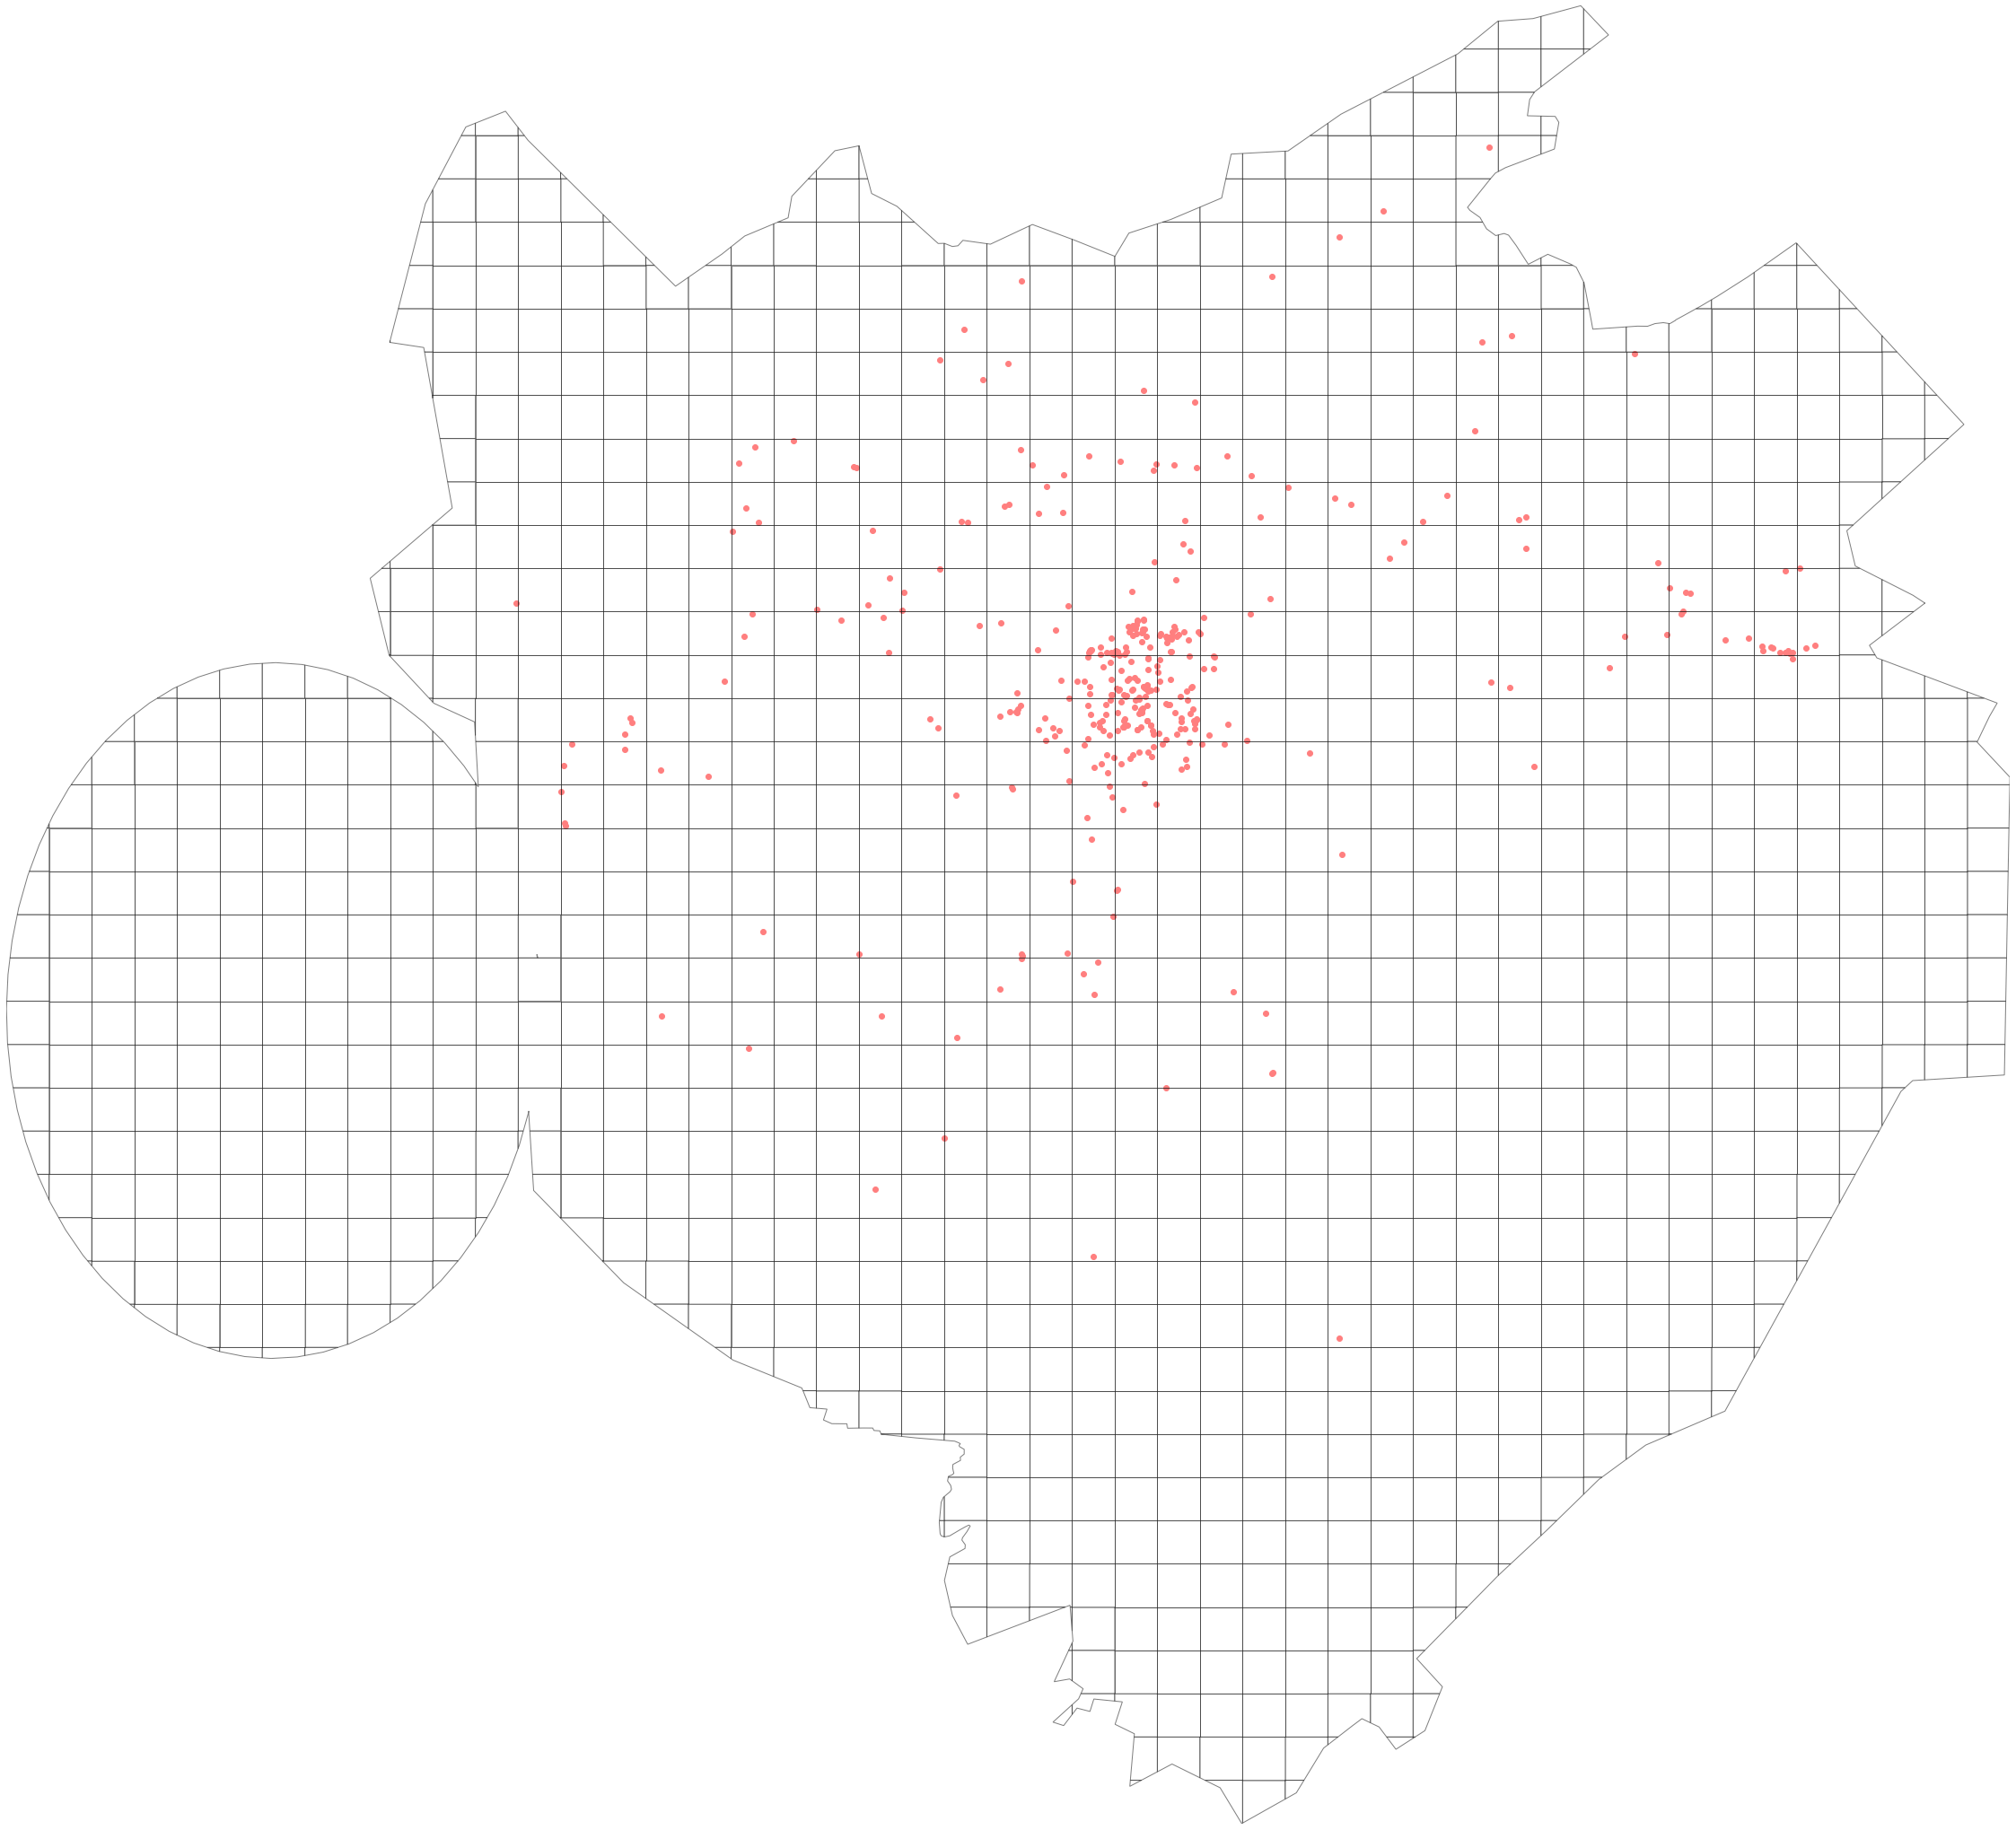

In [48]:
west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
#     plt.annotate(text=n, xy=p,
#                  horizontalalignment='center', size=9)
    
restaurant_shp.plot(ax=ax, color='red', zorder=2)        
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [49]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\gevor\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
cells_restaurantcounts = gpd.sjoin(polyframe, restaurant_shp, op='contains')
cells_restaurantcounts.head()

,geometry,index_right
42,"POLYGON ((452588.734 4447580.180, 452588.734 4...",369
42,"POLYGON ((452588.734 4447580.180, 452588.734 4...",83
43,"POLYGON ((452588.734 4447083.112, 452588.734 4...",305
43,"POLYGON ((452588.734 4447083.112, 452588.734 4...",306
43,"POLYGON ((452588.734 4447083.112, 452588.734 4...",170


In [51]:
restaurantcounts = cells_restaurantcounts.groupby(cells_restaurantcounts.index)['index_right'].count()
counts = pd.DataFrame(restaurantcounts)
counts.columns = ['counts']
counts

,counts
42,2
43,3
67,3
68,1
93,1
...,...
959,9
960,1
984,1
986,2


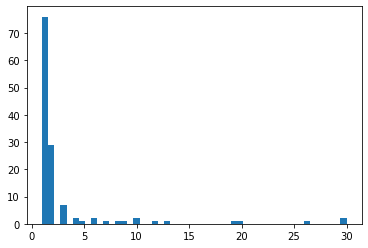

In [52]:
plt.hist(counts.counts, bins=50)
plt.show()

In [53]:
polycounts = polyframe.copy()
polycounts['counts'] = counts.counts
polycounts['counts'].fillna(0, inplace=True)
polycounts['counts'] = polycounts['counts'].astype(int)
polycounts

,geometry,counts
0,"POLYGON ((451733.629 4443336.600, 451728.586 4...",0
1,"POLYGON ((451609.763 4443603.633, 451609.763 4...",0
2,"POLYGON ((451609.763 4444100.702, 451609.763 4...",0
3,"POLYGON ((451609.763 4444597.770, 451609.763 4...",0
4,"POLYGON ((451609.763 4445094.838, 451609.763 4...",0
...,...,...
1294,"POLYGON ((445739.798 4444597.770, 445753.506 4...",0
1295,"POLYGON ((445776.708 4445094.838, 445800.431 4...",0
1296,"POLYGON ((445860.548 4445591.907, 445876.254 4...",0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",0


In [54]:
polycounts[polycounts['counts']==polycounts['counts'].max()]

,geometry,counts
427,"POLYGON ((458952.048 4448574.317, 458952.048 4...",30
428,"POLYGON ((458952.048 4448077.248, 458952.048 4...",30


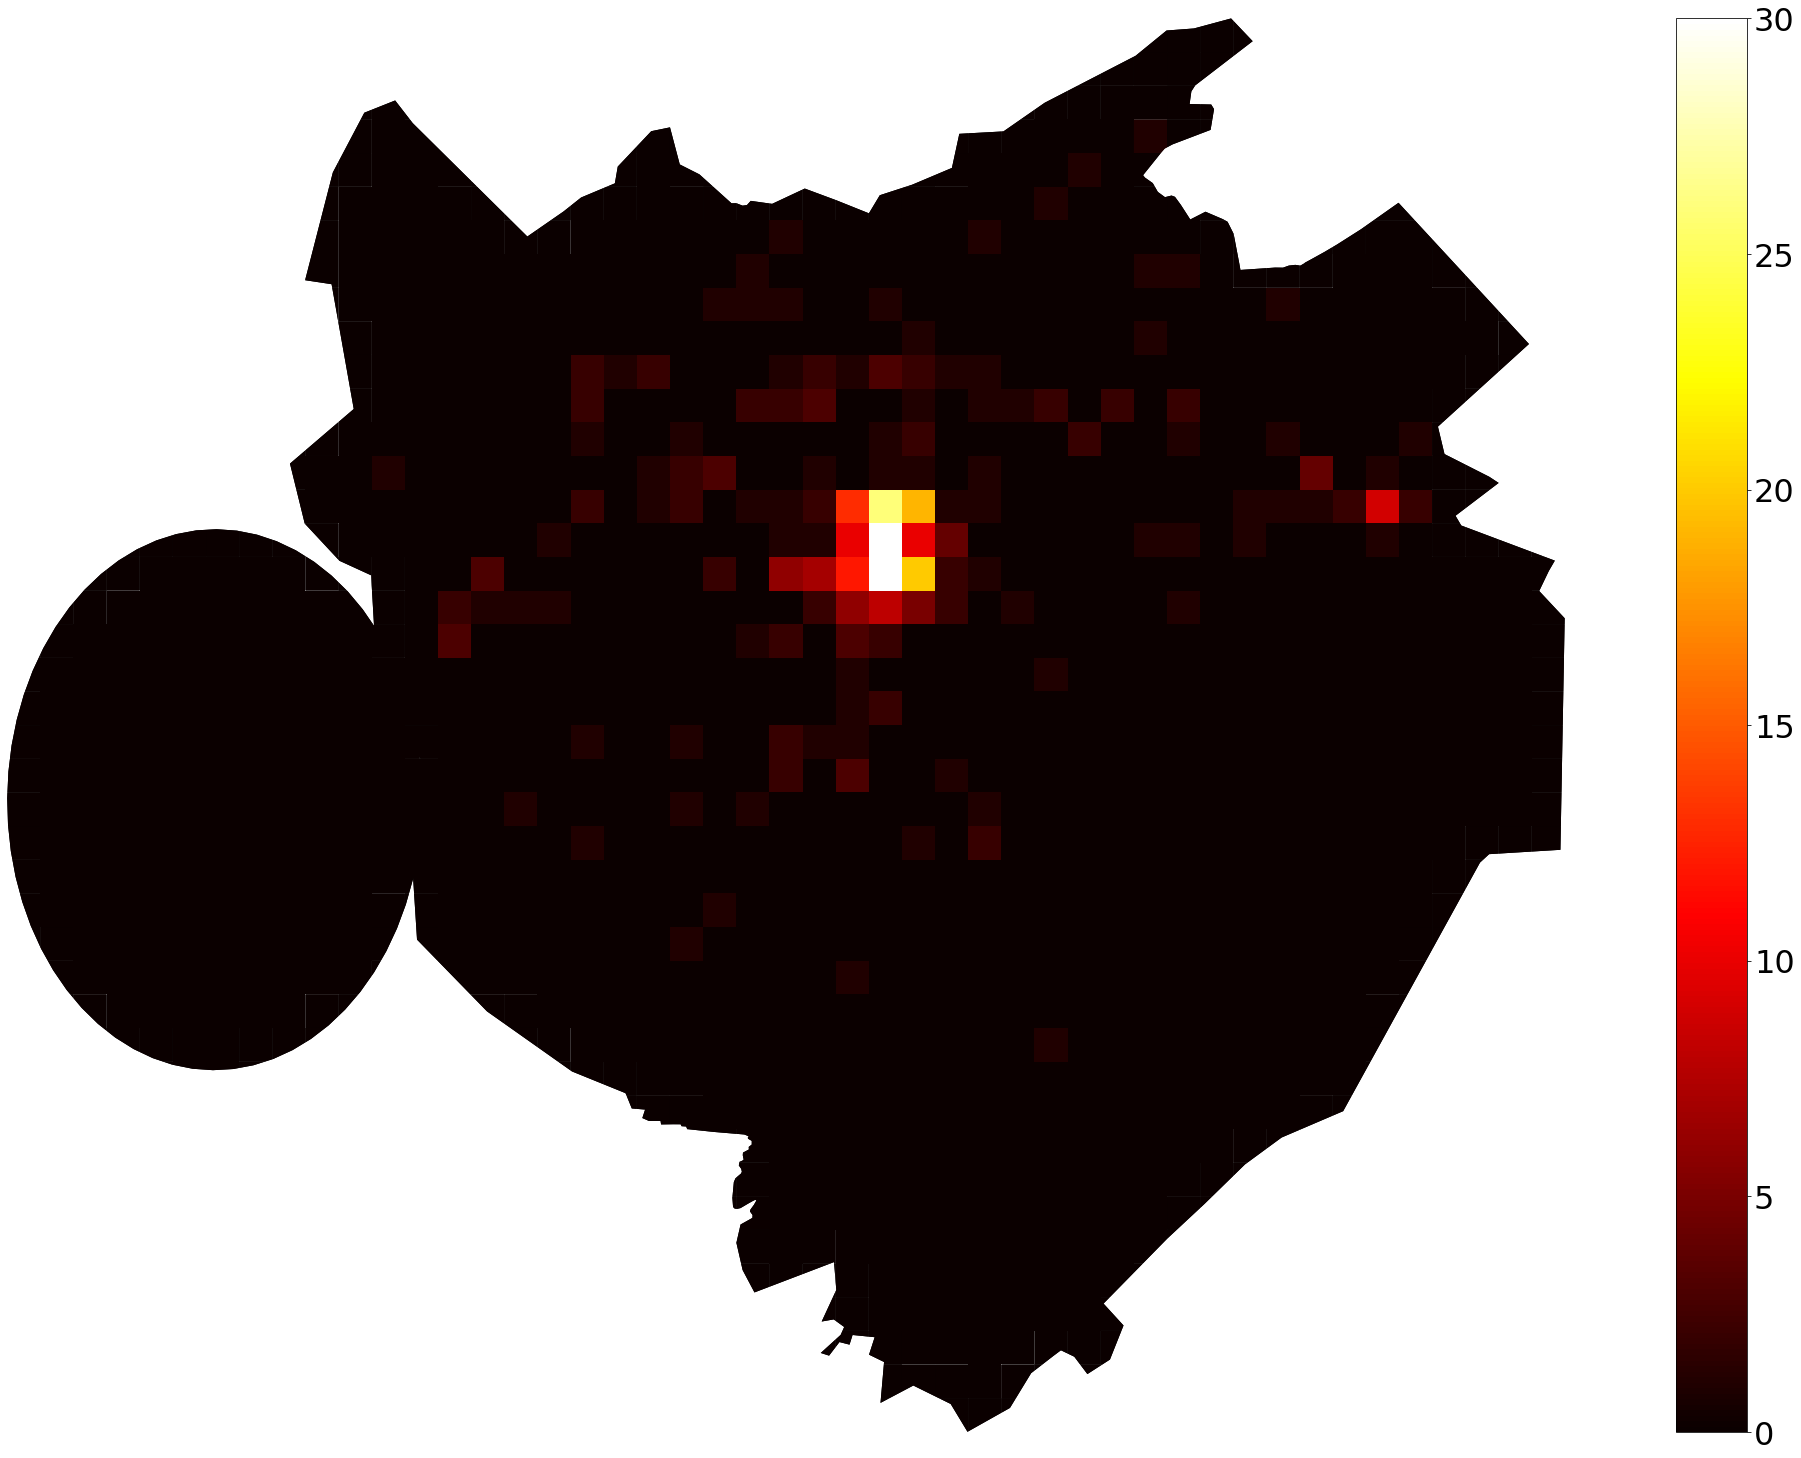

In [55]:
# plot the restaurant count distribution
plt.rcParams.update({'font.size':32})
west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polycounts.plot(column='counts',  legend=True, cmap='hot', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Compute parking areas per grid cell

In [56]:
# get parking areas
parkings = gdf[(gdf["amenity"] == "parking") & \
                  (gdf["geometry"].geom_type == "Polygon")].dropna(axis=1, how="any")
print(parkings.shape)
parkings.reset_index(inplace=True, drop=True)
parkings

(333, 3)


,amenity,geometry,nodes
0,parking,"POLYGON ((44.51767 40.17209, 44.51842 40.17248...","[354448032, 354448045, 354448049, 354448062, 4..."
1,parking,"POLYGON ((44.51709 40.17168, 44.51732 40.17128...","[356293656, 356293662, 356293670, 356293673, 3..."
2,parking,"POLYGON ((44.51221 40.17578, 44.51257 40.17594...","[5163217740, 5163217741, 5163217748, 372615948..."
3,parking,"POLYGON ((44.50838 40.20521, 44.50855 40.20517...","[611776642, 611776643, 611776645, 611776649, 6..."
4,parking,"POLYGON ((44.54402 40.21644, 44.54394 40.21638...","[612616217, 612616218, 612616219, 612616220, 6..."
...,...,...,...
328,parking,"POLYGON ((44.53125 40.19177, 44.53117 40.19183...","[8010032628, 8010032627, 8010032626, 801003262..."
329,parking,"POLYGON ((44.49229 40.22358, 44.49217 40.22350...","[2334325118, 8201776319, 8201776318, 820177631..."
330,parking,"POLYGON ((44.52313 40.13167, 44.52314 40.13198...","[8354225570, 8354225571, 8354225575, 835422557..."
331,parking,"POLYGON ((44.52375 40.17951, 44.52385 40.17941...","[8458373781, 356299288, 356299285, 8458373780,..."


In [57]:
parking_shp = parkings[['geometry']]
parking_shp= parking_shp.copy()
parking_shp

,geometry
0,"POLYGON ((44.51767 40.17209, 44.51842 40.17248..."
1,"POLYGON ((44.51709 40.17168, 44.51732 40.17128..."
2,"POLYGON ((44.51221 40.17578, 44.51257 40.17594..."
3,"POLYGON ((44.50838 40.20521, 44.50855 40.20517..."
4,"POLYGON ((44.54402 40.21644, 44.54394 40.21638..."
...,...
328,"POLYGON ((44.53125 40.19177, 44.53117 40.19183..."
329,"POLYGON ((44.49229 40.22358, 44.49217 40.22350..."
330,"POLYGON ((44.52313 40.13167, 44.52314 40.13198..."
331,"POLYGON ((44.52375 40.17951, 44.52385 40.17941..."


In [58]:
# check for NaN values
print(parking_shp.isna().values.any())

False


In [59]:
parking_shp.geometry = parking_shp.geometry.to_crs(polyframe.crs)
parking_shp.head()

,geometry
0,"POLYGON ((458932.014 4446968.855, 458995.720 4..."
1,"POLYGON ((458882.659 4446924.358, 458901.676 4..."
2,"POLYGON ((458469.025 4447381.863, 458500.136 4..."
3,"POLYGON ((458161.117 4450650.331, 458175.653 4..."
4,"POLYGON ((461200.476 4451879.958, 461193.685 4..."


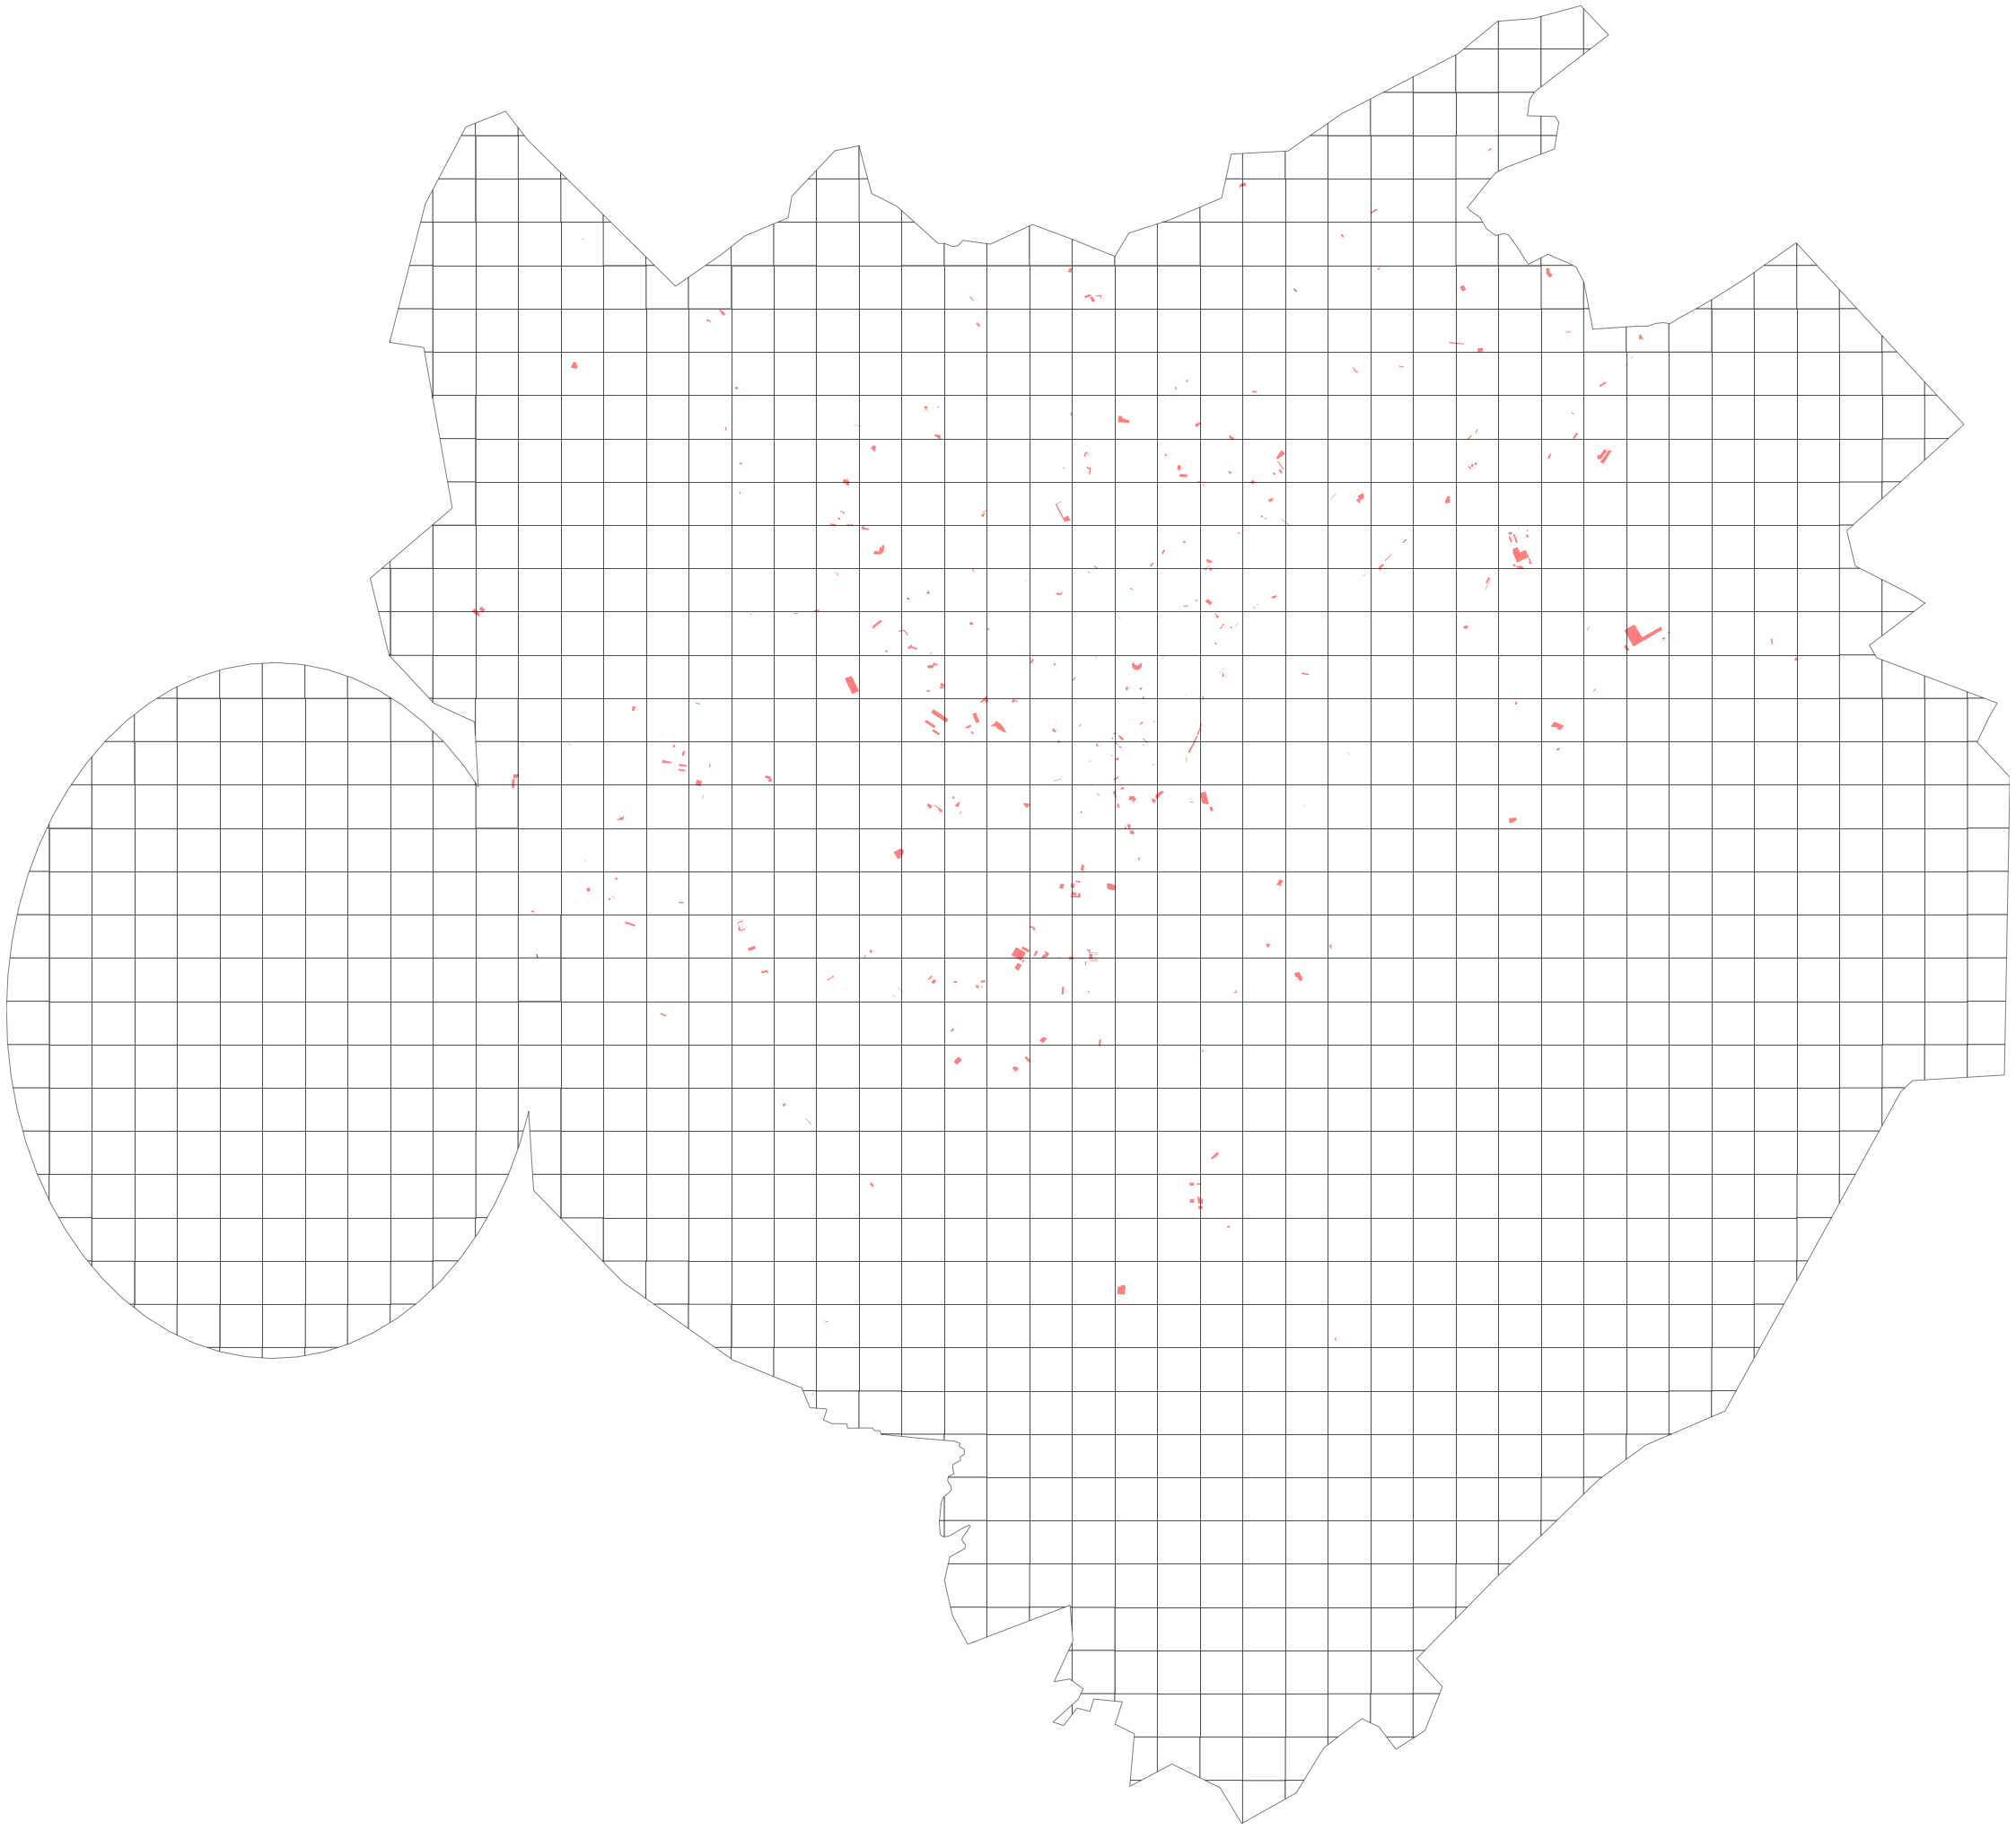

In [60]:
west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
#     plt.annotate(text=n, xy=p,
#                  horizontalalignment='center', size=9)
    
parking_shp.plot(ax=ax, color='red', zorder=2)        
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [61]:
# compute parking area per cell
parking_shp['area'] = parking_shp.geometry.area
parking_shp

,geometry,area
0,"POLYGON ((458932.014 4446968.855, 458995.720 4...",3830.909430
1,"POLYGON ((458882.659 4446924.358, 458901.676 4...",1590.188396
2,"POLYGON ((458469.025 4447381.863, 458500.136 4...",946.042024
3,"POLYGON ((458161.117 4450650.331, 458175.653 4...",1845.808191
4,"POLYGON ((461200.476 4451879.958, 461193.685 4...",1076.036021
...,...,...
328,"POLYGON ((460099.984 4449147.198, 460093.140 4...",116.914997
329,"POLYGON ((456803.355 4452696.942, 456792.947 4...",720.035352
330,"POLYGON ((459373.062 4442480.074, 459373.362 4...",1609.035423
331,"POLYGON ((459453.639 4447789.719, 459462.197 4...",1890.403830


In [62]:
# maximum parking area:
parking_shp.area.max()

39637.81600941138

In [63]:
cells_parkingcounts = gpd.sjoin(polyframe, parking_shp, op='intersects')
cells_parkingcounts.head()

,geometry,index_right,area
5,"POLYGON ((451609.763 4445591.907, 451609.763 4...",163,589.881307
8,"POLYGON ((451609.763 4447083.112, 451609.763 4...",171,2312.541925
1081,"POLYGON ((451153.011 4447083.112, 451124.376 4...",171,2312.541925
30,"POLYGON ((452588.734 4453545.000, 452588.734 4...",213,180.779782
33,"POLYGON ((452588.734 4452053.795, 452588.734 4...",25,3973.206151


In [64]:
parkingcounts = cells_parkingcounts.groupby(cells_parkingcounts.index)['area'].sum()
counts = pd.DataFrame(parkingcounts)
counts.columns = ['counts']
counts

,counts
5,589.881307
8,2312.541925
30,180.779782
33,3973.206151
42,173.473000
...,...
1081,5060.044107
1084,6146.279694
1085,6146.279694
1115,3917.214914


In [65]:
# maximum parking area per cell
counts.counts.max()

42954.74605054174

In [66]:
polycounts = polyframe.copy()
polycounts['area'] = counts.counts
polycounts['area'].fillna(0, inplace=True)
polycounts

,geometry,area
0,"POLYGON ((451733.629 4443336.600, 451728.586 4...",0.0
1,"POLYGON ((451609.763 4443603.633, 451609.763 4...",0.0
2,"POLYGON ((451609.763 4444100.702, 451609.763 4...",0.0
3,"POLYGON ((451609.763 4444597.770, 451609.763 4...",0.0
4,"POLYGON ((451609.763 4445094.838, 451609.763 4...",0.0
...,...,...
1294,"POLYGON ((445739.798 4444597.770, 445753.506 4...",0.0
1295,"POLYGON ((445776.708 4445094.838, 445800.431 4...",0.0
1296,"POLYGON ((445860.548 4445591.907, 445876.254 4...",0.0
1297,"POLYGON ((445998.765 4446088.975, 446111.385 4...",0.0


In [67]:
# check which cell contains maximum parking area
polycounts[polycounts['area']==polycounts['area'].max()]

,geometry,area
875,"POLYGON ((464825.876 4449071.385, 464825.876 4...",42954.746051


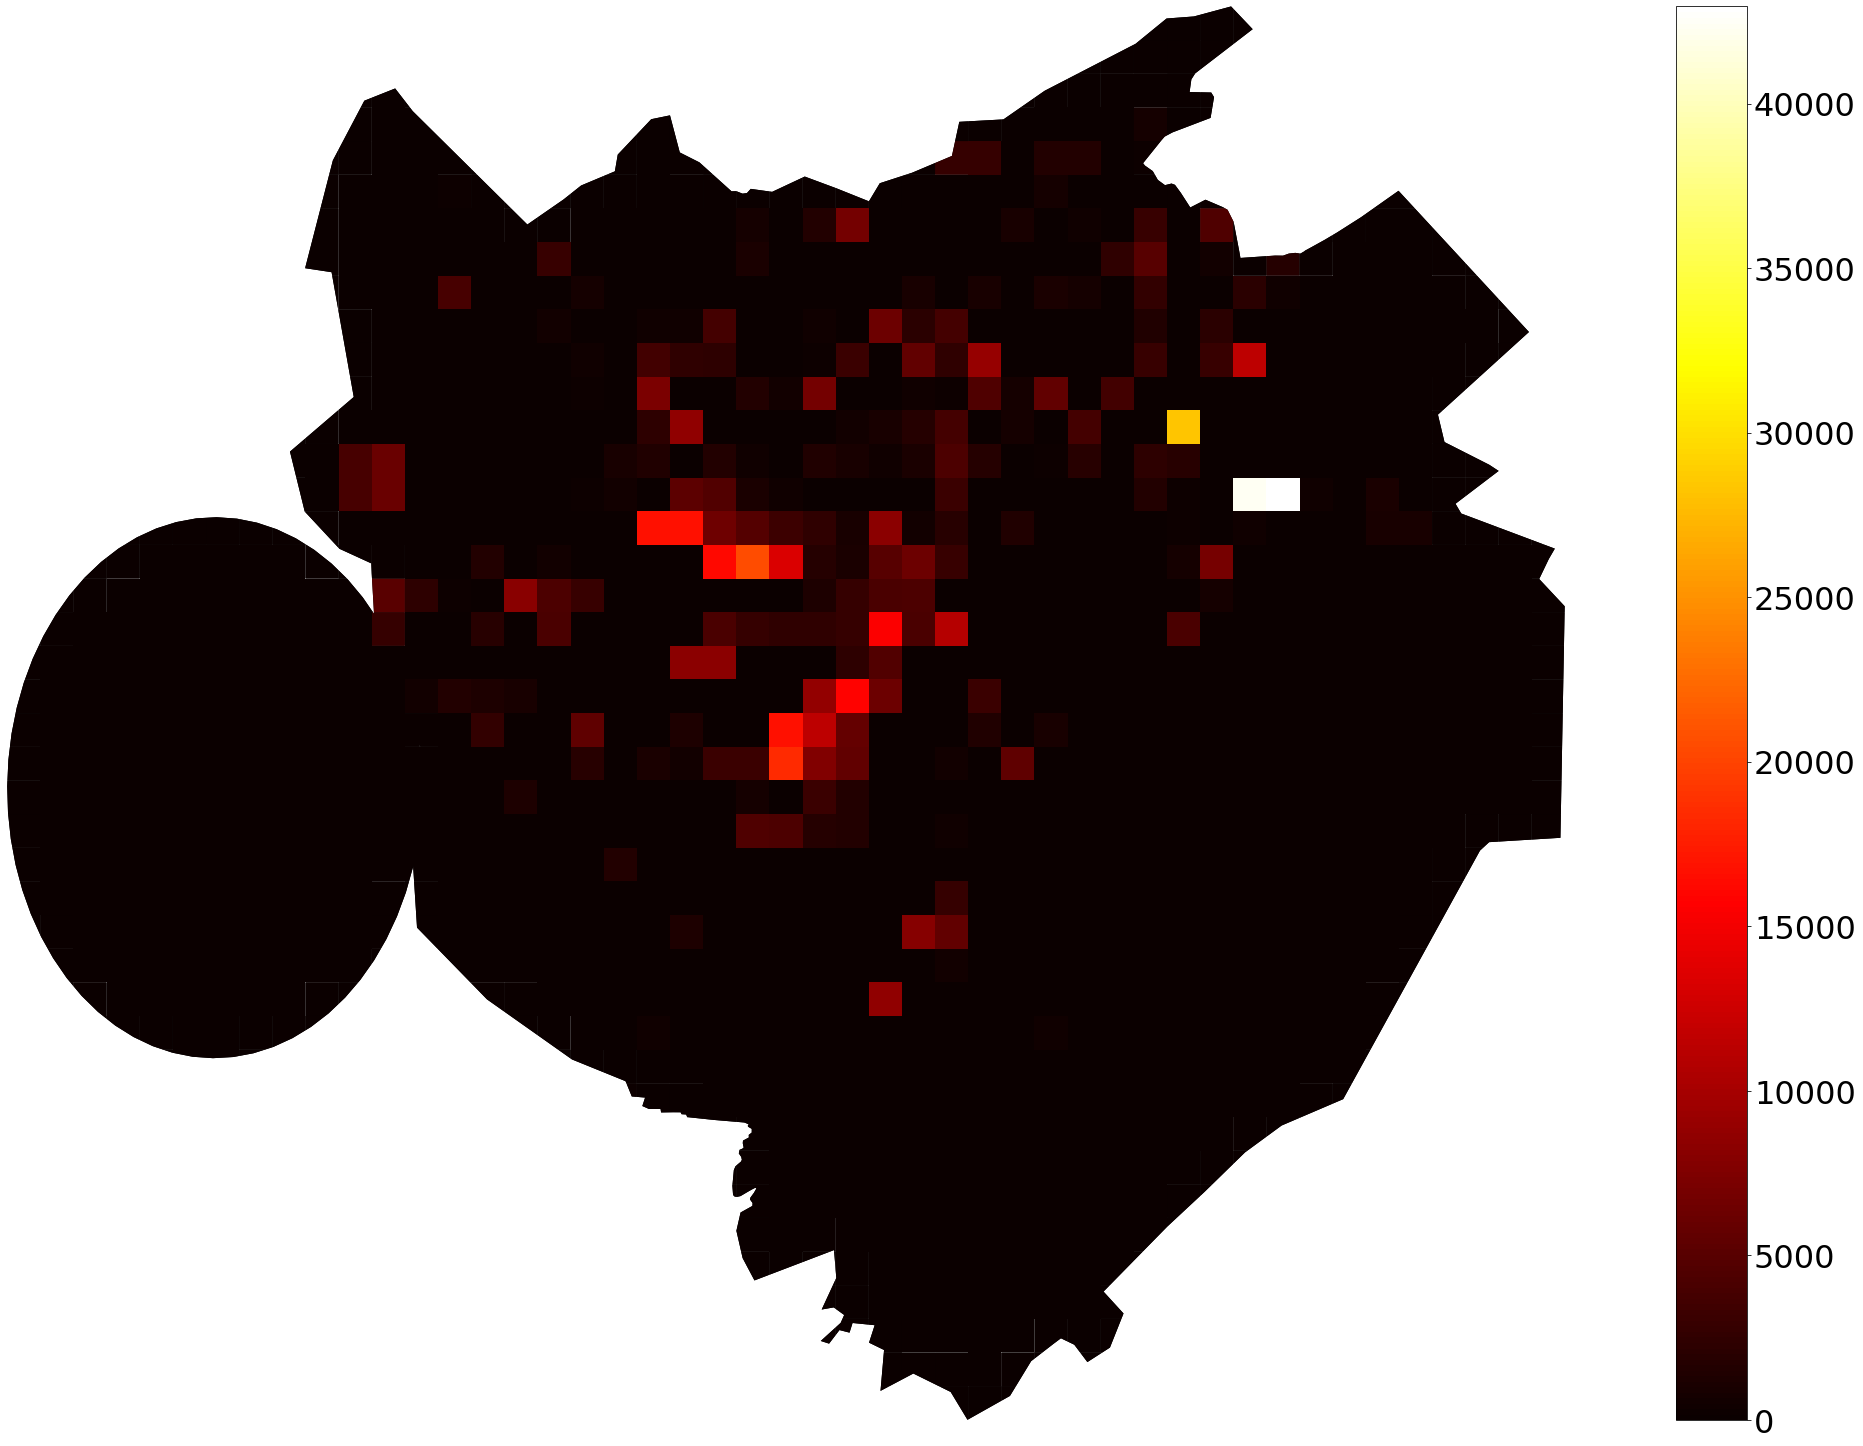

In [68]:
# plot the parking area distribution
plt.rcParams.update({'font.size':32})
west, south, east, north = yerevan.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polycounts.plot(column='area',  legend=True, cmap='hot', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

### Introduction to GPS data in Python

In [69]:
# import Yerevan taxi vehicle gps data set
data = pd.read_csv('../data/Yerevan_gps_data.csv', \
                   header=0, index_col=0, nrows=2*10**6)
print(len(data))
data.tail()

2000000


C:\Users\gevor\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,createdAt,partnerId,lat,lon,status
1999995,2019-03-20 09:35:28,31939,40.211296,44.471706,0
1999996,2019-03-20 09:35:47,31939,40.211324,44.471693,0
1999997,2019-03-20 09:35:56,31939,40.211312,44.471718,0
1999998,2019-03-20 09:36:13,31939,40.211312,44.471717,0
1999999,2019-03-20 09:36:24,31939,40.211313,44.471715,0


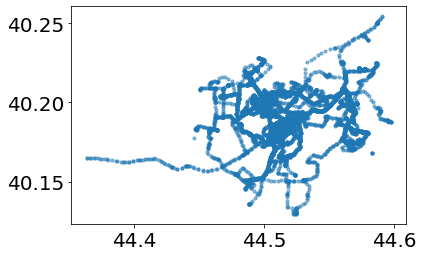

In [70]:
# plot a sample of GPS points
plt.rcParams.update({'font.size':20})
plt.scatter(data.loc[:10000, 'lon'],data.loc[:10000, 'lat'], alpha=0.5, s=10)
plt.show()

In [71]:
# create Point geometries from lat and lon coordinates
geometry = [Point(xy) for xy in zip(data.lon, data.lat)] #list comprehension
crs = CRS.from_epsg(4326)
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
gdf.head()

,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (44.44599 40.17727)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (44.49610 40.19993)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (44.57209 40.17507)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (44.57210 40.17505)


In [72]:
print(polyframe.crs)
#convert GPS point geodataframe to the local coordinate reference system

gdf.geometry = gdf.geometry.to_crs(polyframe.crs)
gdf.head()

+proj=utm +zone=38 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


,createdAt,partnerId,lat,lon,status,geometry
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (452832.035 4447579.433)
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (457112.862 4450069.794)
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (463567.204 4447276.695)
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (463568.220 4447273.748)


In [73]:
gdf['pt_dists'] = gdf.geometry.distance(gdf.geometry.shift(1))
gdf.head()

,createdAt,partnerId,lat,lon,status,geometry,pt_dists
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (452832.035 4447579.433),NaN
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (457112.862 4450069.794),4952.512717
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (457112.862 4450069.794),0.000000
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (463567.204 4447276.695),7032.775522
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (463568.220 4447273.748),3.116580


In [74]:
gdf = gdf.fillna(0)
gdf.head(10)

,createdAt,partnerId,lat,lon,status,geometry,pt_dists
0,2019-03-31 15:11:10,2,40.177266,44.445987,0,POINT (452832.035 4447579.433),0.000000
1,2019-03-15 16:29:56,12,40.199932,44.496100,0,POINT (457112.862 4450069.794),4952.512717
2,2019-03-15 16:30:27,12,40.199932,44.496100,0,POINT (457112.862 4450069.794),0.000000
3,2019-03-18 20:17:29,12,40.175073,44.572091,0,POINT (463567.204 4447276.695),7032.775522
4,2019-03-18 20:17:45,12,40.175047,44.572103,0,POINT (463568.220 4447273.748),3.116580
5,2019-03-18 20:18:01,12,40.175078,44.572149,0,POINT (463572.162 4447277.159),5.212435
6,2019-03-18 20:18:17,12,40.175108,44.572183,0,POINT (463575.039 4447280.520),4.423773
7,2019-03-18 20:18:25,12,40.175108,44.572183,0,POINT (463575.090 4447280.553),0.060980
8,2019-03-18 20:18:45,12,40.175135,44.572207,0,POINT (463577.130 4447283.495),3.580977
9,2019-03-18 20:19:01,12,40.175172,44.572233,0,POINT (463579.364 4447287.547),4.626430


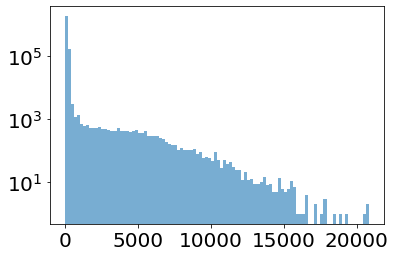

In [75]:
# let's do a quick histogram of distances between GPS point samples
plt.hist(gdf.pt_dists, bins=100, alpha=0.6, log=True)
plt.show()

### Homework assignments

1. Draw a snowman with shapely or/and GeoPandas :)

2. Use the grid cell polygons of Yerevan city and compute the distance between the centroid of the grid cell with highest parking area and the centroid of all of Yerevan city.

3. Take a driver (`partnerId` column) of your choice from the taxi vehicle GPS data set, compute the distances from all GPS points of that driver to the geometric center of its GPS positions, or to the Yerevan polygon centroid, and plot the resulting distribution of distances. 

Complete all tasks in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Class 2 Homework** and upload it to Moodle.